<center>
  <h1><b>DLMI - Lymphocytosis classifications </b></h1>
  <br>
  25 / 02 / 2024
  <br>
  <br>
  <b>Students name:</b>  Aissa & Valentin
  <br>
  <br>
  </center>

# Environment set up

In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, recall_score
from sklearn.model_selection import KFold

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import and Analyse the Dataset

In [3]:
!unzip /content/drive/MyDrive/DL_Medical/dlmi-lymphocytosis-classification.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: trainset/P27/000009.jpg  
  inflating: trainset/P27/000010.jpg  
  inflating: trainset/P27/000011.jpg  
  inflating: trainset/P27/000012.jpg  
  inflating: trainset/P27/000013.jpg  
  inflating: trainset/P27/000014.jpg  
  inflating: trainset/P27/000015.jpg  
  inflating: trainset/P27/000016.jpg  
  inflating: trainset/P27/000017.jpg  
  inflating: trainset/P27/000018.jpg  
  inflating: trainset/P27/000019.jpg  
  inflating: trainset/P27/000020.jpg  
  inflating: trainset/P27/000021.jpg  
  inflating: trainset/P27/000022.jpg  
  inflating: trainset/P27/000023.jpg  
  inflating: trainset/P27/000024.jpg  
  inflating: trainset/P27/000025.jpg  
  inflating: trainset/P27/000026.jpg  
  inflating: trainset/P27/000027.jpg  
  inflating: trainset/P27/000028.jpg  
  inflating: trainset/P27/000029.jpg  
  inflating: trainset/P27/000030.jpg  
  inflating: trainset/P27/000031.jpg  
  inflating: trainset/P27

In [4]:
annotation = pd.read_csv("/content/trainset/trainset_true.csv")
annotation.head()

,ID,LABEL,GENDER,DOB,LYMPH_COUNT
0,P26,1,M,11/3/1933,11.2
1,P183,1,M,5/15/1942,12.8
2,P89,1,M,6/19/1935,9.6
3,P123,1,M,1/27/1931,122.6
4,P61,1,F,3/5/1931,11.6


In [5]:
# Set 'ID' as the index
annotation.set_index('ID', inplace=True)

# Function to return label given ID
def get_label(ID):
    return annotation.loc[ID, 'LABEL']

ID = 'P26'
label = get_label(ID)
print(f"The label for ID '{ID}' is: {label}")

The label for ID 'P26' is: 1


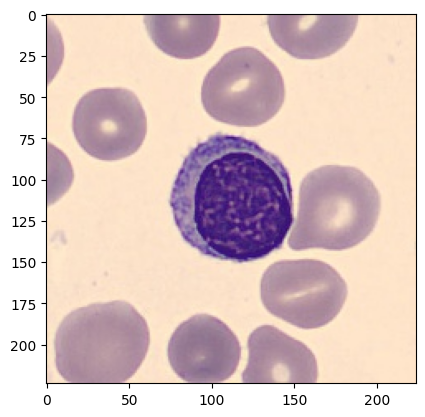

Image dimensions (width, height): 224 224


In [6]:
image_path = "/content/trainset/P2/000132.jpg"
image = Image.open(image_path)
plt.imshow(image)
plt.show()
# Get the width and height of the image
width, height = image.size
print("Image dimensions (width, height):", width, height)

# Analyzing the data

In [8]:
# Load annotation data
train_dt = pd.read_csv("/content/trainset/trainset_true.csv")

LYMPH_COUNT versus LABEL

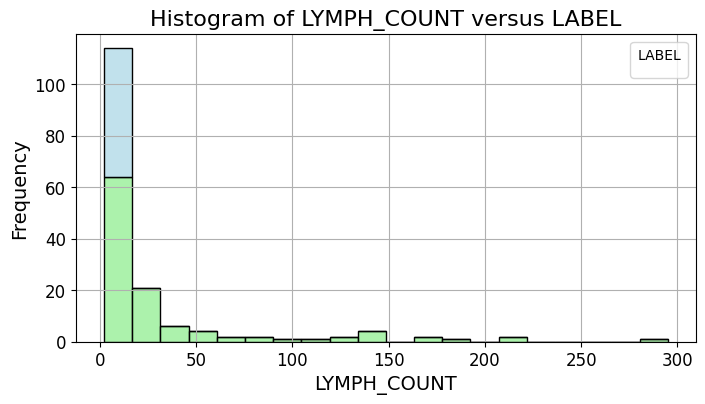

In [9]:
# Define the color palette
label_palette = {0: 'lightblue', 1: 'lightgreen'}
plt.figure(figsize=(8, 4))
sns.histplot(data=train_dt, x='LYMPH_COUNT', hue='LABEL', bins=20, multiple='stack', palette=label_palette)
plt.title('Histogram of LYMPH_COUNT versus LABEL', fontsize=16)
plt.xlabel('LYMPH_COUNT', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='LABEL', loc='upper right', fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Gender verses Labels

<Figure size 800x400 with 0 Axes>

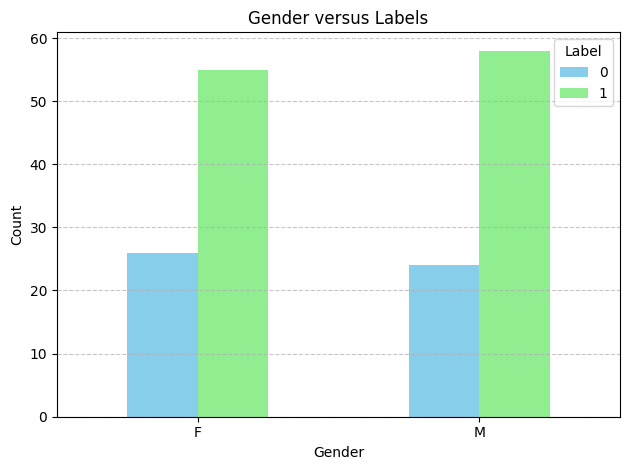

In [10]:
annotation['GENDER'] = annotation['GENDER'].str.upper()
gender_counts = annotation['GENDER'].value_counts()
gender_label_cross = pd.crosstab(annotation['GENDER'], annotation['LABEL'])
# Plot
plt.figure(figsize=(8, 4))
gender_label_cross.plot(kind='bar', color=['skyblue', 'lightgreen', 'pink'])
plt.title('Gender versus Labels')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Label')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
# Applying the mapping to the 'GENDER' column
gender_mapping = {'M': 0, 'F': 1,'f': 1}
train_dt['SEX'] = train_dt['GENDER'].map(gender_mapping)

Age Versus Labels

<ipython-input-12-7e13427da086>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  annotation['DOB'] = pd.to_datetime(annotation['DOB'])


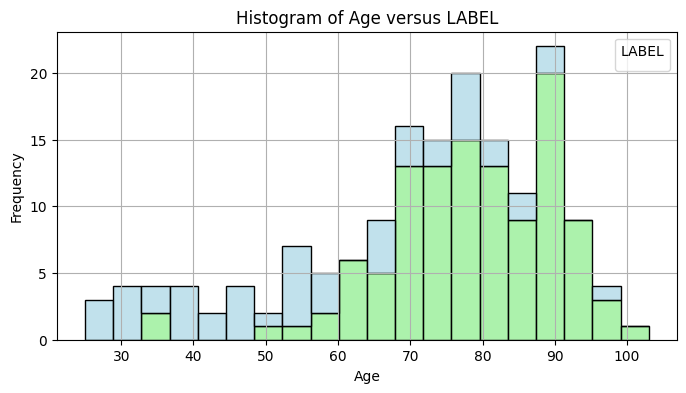

In [12]:
#Generate and plot the distribution of the Age attribute
annotation['DOB'] = pd.to_datetime(annotation['DOB'])
annotation['Age'] = (pd.Timestamp.now() - annotation['DOB']).astype('<m8[Y]')
label_palette = {0: 'lightblue', 1: 'lightgreen'}
plt.figure(figsize=(8, 4))
sns.histplot(data=annotation, x='Age', hue='LABEL', bins=20, multiple='stack', palette =label_palette)
plt.title('Histogram of Age versus LABEL')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(title='LABEL', loc='upper right')
plt.grid(True)
plt.show()

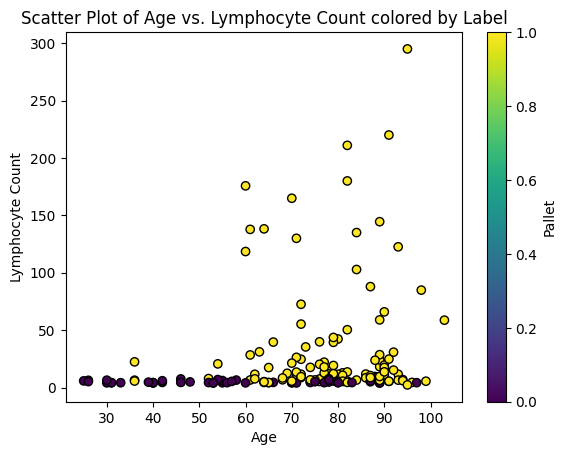

In [13]:
# Scatter Plot of Age vs. Lymphocyte Count colored by Label
scatter_plot = plt.scatter(annotation['Age'], annotation['LYMPH_COUNT'], c=annotation['LABEL'], cmap='viridis', marker='o', edgecolors='black')
plt.xlabel('Age')
plt.ylabel('Lymphocyte Count')
plt.title('Scatter Plot of Age vs. Lymphocyte Count colored by Label')
cbar = plt.colorbar(scatter_plot)
cbar.set_label('Pallet')
plt.show()


Investigate the region where LYMPH_COUNT < 10

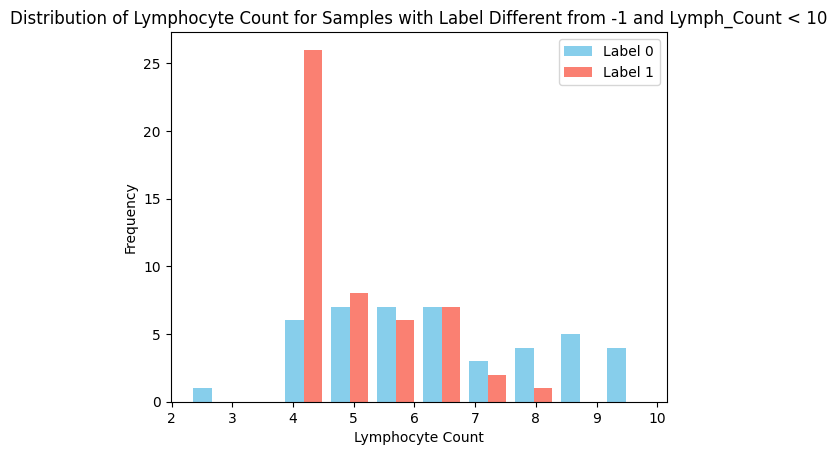

In [14]:
df = annotation
filtered_data = df[(df['LABEL'] != -1) & (df['LYMPH_COUNT'] < 10)]
plt.hist([filtered_data[filtered_data['LABEL'] == label]['LYMPH_COUNT'] for label in filtered_data['LABEL'].unique()],
         bins=10, color=['skyblue', 'salmon'], label=['Label 0', 'Label 1'])

plt.xlabel('Lymphocyte Count')
plt.ylabel('Frequency')
plt.title('Distribution of Lymphocyte Count for Samples with Label Different from -1 and Lymph_Count < 10')
plt.legend()
plt.show()

94


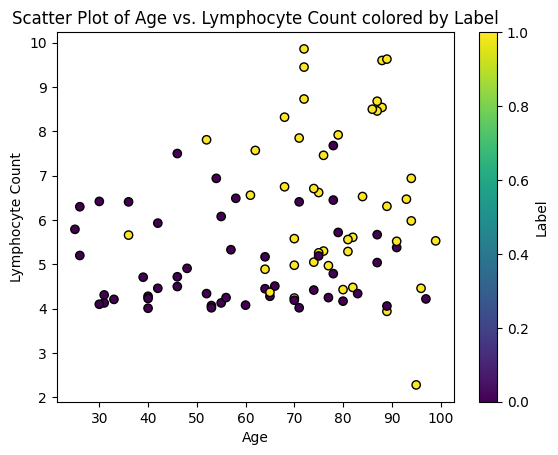

In [15]:
print(len(filtered_data))
plt.scatter(filtered_data['Age'], filtered_data['LYMPH_COUNT'], c=filtered_data['LABEL'], cmap='viridis', marker='o', edgecolors='black')
plt.xlabel('Age')
plt.ylabel('Lymphocyte Count')
plt.title('Scatter Plot of Age vs. Lymphocyte Count colored by Label')
cbar = plt.colorbar()
cbar.set_label('Label')
plt.show()

We notice that in this region it hard to predict using only the Age and Lymphocyte attributes

# Baseline

we use LYMPH_COUNT to predict the label :  

In [16]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold


In [17]:
# Load annotation data
train_dt = pd.read_csv("/content/trainset/trainset_true.csv")
train_dt.head()
train_dt['DOB'] = pd.to_datetime(train_dt['DOB'])
train_dt['Age'] = (pd.Timestamp.now() - train_dt['DOB']).astype('<m8[Y]')
gender_mapping = {'M': 0, 'F': 1,'f': 1}
train_dt['SEX'] = train_dt['GENDER'].map(gender_mapping)
train_dt.head()

<ipython-input-17-1f069a7c35ff>:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  train_dt['DOB'] = pd.to_datetime(train_dt['DOB'])


,ID,LABEL,GENDER,DOB,LYMPH_COUNT,Age,SEX
0,P26,1,M,1933-11-03,11.2,90.0,0
1,P183,1,M,1942-05-15,12.8,81.0,0
2,P89,1,M,1935-06-19,9.6,88.0,0
3,P123,1,M,1931-01-27,122.6,93.0,0
4,P61,1,F,1931-03-05,11.6,93.0,1


In [18]:
train_dt['DOB'] = pd.to_datetime(train_dt['DOB'])
train_dt['Age'] = (pd.Timestamp.now() - train_dt['DOB']).astype('<m8[Y]')
gender_mapping = {'M': 0, 'F': 1,'f': 1}
train_dt['SEX'] = train_dt['GENDER'].map(gender_mapping)
train_dt.head()

,ID,LABEL,GENDER,DOB,LYMPH_COUNT,Age,SEX
0,P26,1,M,1933-11-03,11.2,90.0,0
1,P183,1,M,1942-05-15,12.8,81.0,0
2,P89,1,M,1935-06-19,9.6,88.0,0
3,P123,1,M,1931-01-27,122.6,93.0,0
4,P61,1,F,1931-03-05,11.6,93.0,1


Accuracy: 0.8307692307692308
Balanced Accuracy: 0.8189935064935066
f1-score: 0.872093023255814
recall: 0.8522727272727273


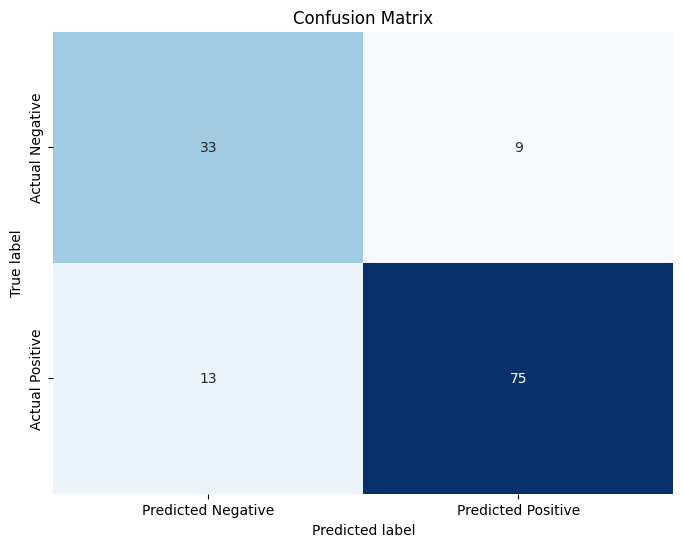

Accuracy: 0.8153846153846154
Balanced Accuracy: 0.8076298701298701
f1-score: 0.8588235294117648
recall: 0.8295454545454546


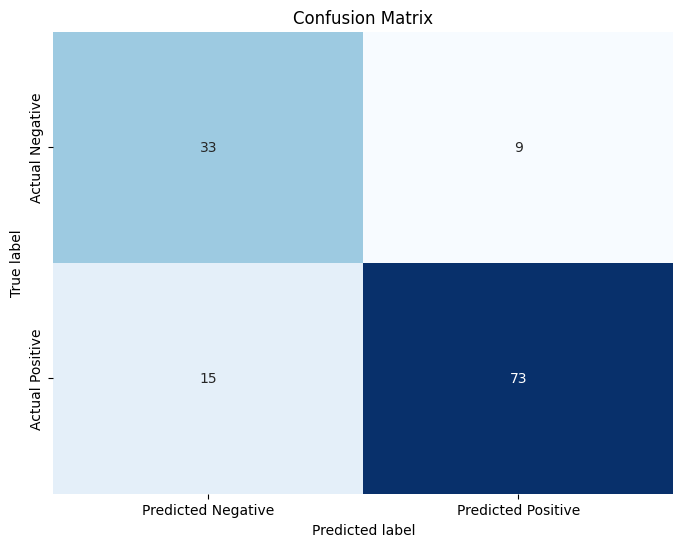

Accuracy: 0.823076923076923
Balanced Accuracy: 0.8031095611740773
f1-score: 0.8729281767955801
recall: 0.8494623655913979


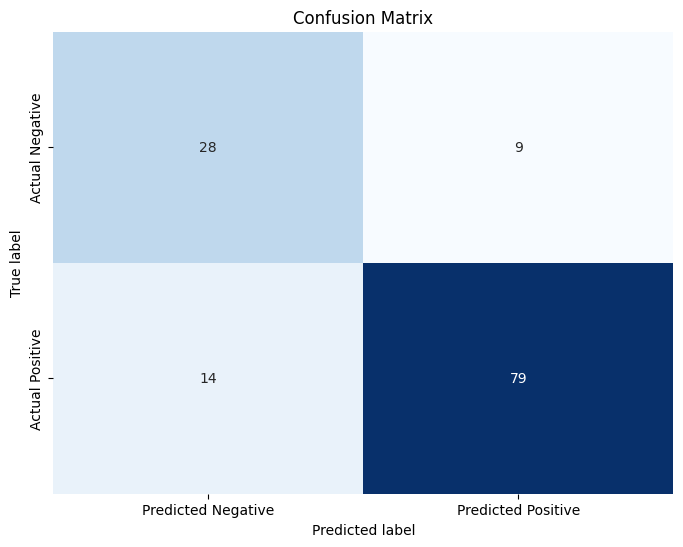

In [19]:

# 3-folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
counter = 0
for train_index, test_index in kf.split(df):
    if counter == 3:
      break
    train_data = train_dt.iloc[train_index]
    test_data = train_dt.iloc[test_index]
    counter+=1

    # Assuming df contains your dataset with columns 'LYMPH_COUNT', 'Age', and 'target'
    X_train = train_data[['LYMPH_COUNT', 'Age','SEX']]
    y_train = train_data['LABEL']
    X_test = train_data[['LYMPH_COUNT', 'Age','SEX']]
    y_test = train_data['LABEL']


    # Calculate class weights
    class_weights = dict(zip(y_train.unique(), (1 / y_train.value_counts(normalize=True))))

    # Initialize SVM classifier with class weighting
    model_SVM = SVC(class_weight=class_weights)

    # Train the model
    model_SVM.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = model_SVM.predict(X_test)

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1_s= f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Balanced Accuracy:", balanced_accuracy)
    print("f1-score:", f1_s)
    print("recall:", recall)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

# First Submit

In [20]:
# Load annotation data
test_dt = pd.read_csv("/content/clinical_annotation.csv")
test_dt['DOB'] = pd.to_datetime(test_dt['DOB'])
test_dt['Age'] = (pd.Timestamp.now() - test_dt['DOB']).astype('<m8[Y]')
gender_mapping = {'M': 0, 'F': 1, 'f': 1}
test_dt['SEX'] = test_dt['GENDER'].map(gender_mapping)
test_dt.head()

<ipython-input-20-4590c37e41d7>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  test_dt['DOB'] = pd.to_datetime(test_dt['DOB'])


,Unnamed: 0,ID,LABEL,GENDER,DOB,LYMPH_COUNT,Age,SEX
0,0,P26,1,M,1933-11-03,11.2,90.0,0
1,1,P183,1,M,1942-05-15,12.8,81.0,0
2,2,P89,1,M,1935-06-19,9.6,88.0,0
3,3,P123,1,M,1931-01-27,122.6,93.0,0
4,4,P61,1,F,1931-03-05,11.6,93.0,1


In [21]:
X_test = test_dt[['LYMPH_COUNT', 'Age','SEX']]
# Predictions on the test set
y_pred = model_SVM.predict(X_test)
# Create a DataFrame
submission_df = pd.DataFrame({'ID': test_dt["ID"], 'Predicted': y_pred})
# Save DataFrame to a CSV file
submission_df.to_csv('submission001.csv', index=False)

# Developed Model: Enhanced Classification Approach

# Preparing the data

In [22]:
import os
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold
import random
import torchvision.transforms.functional as F


class CustomDataset(Dataset):
    def __init__(self, data_dir, annotation, transform=None, split=None, fold=None):
        self.data_dir = data_dir
        self.transform = transform
        self.patients = [patient for patient in os.listdir(data_dir) if patient not in (".ipynb_checkpoints", "trainset_true.csv","testset_data.csv")]
        self.labels = annotation.set_index('ID')['LABEL']
        self.annotation = annotation
        self.split = split
        self.fold = fold

        # 3-folds cross validation
        if self.split != None: #to avoid splitting the test set
          kf = KFold(n_splits=5, shuffle=True, random_state=42) #80% training, 20%validatio,
          folds = []
          for train_indices, val_indices in kf.split(self.patients):
              folds.append([train_indices, val_indices])
          train_indices, val_indices = folds[self.fold - 1]

          if self.split == 'train':
              self.patients = [self.patients[i] for i in train_indices]
          elif self.split == 'val':
              self.patients = [self.patients[i] for i in val_indices]

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        # Fetch Features
        #print(self.patients[idx])
        patient_id = self.patients[idx]  # Fetch patient ID
        patient_info = self.annotation[self.annotation['ID'] == patient_id].iloc[0]
        age = patient_info['Age']
        lymph_count = patient_info['LYMPH_COUNT']
        sex=patient_info['SEX']

        # Fetch Images
        patient_folder = os.path.join(self.data_dir, self.patients[idx])
        images = []
        image_files = os.listdir(patient_folder)
        #print(image_files)
        for i, image_file in enumerate(image_files):
            if i > 10 and self.split == None : #only for test
              break
            image_path = os.path.join(patient_folder, image_file)
            image = Image.open(image_path)
            if self.transform:
                image = self.transform(image)
            images.append(image)

        label = self.labels[patient_id]  # Fetch label for the patient
        return torch.stack(images), age, lymph_count, sex, label, int(patient_id[1:])

# Compose the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



train_data_dir = '/content/trainset/'
test_data_dir = '/content/testset/'
batch_size=1

#Initialize datasets
train_dataset = CustomDataset(train_data_dir, train_dt, transform=transform, split='train', fold=3)
val_dataset = CustomDataset(train_data_dir, train_dt, transform=transform, split='val', fold=3)
test_dataset = CustomDataset(test_data_dir, train_dt, transform=transform)

# Initialize data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Batch 1:
Images shape: torch.Size([1, 11, 3, 224, 224])
Age and Lymph Count: [tensor([42.3100], dtype=torch.float64), tensor([80.], dtype=torch.float64), tensor([0])]
Labels: tensor([1])


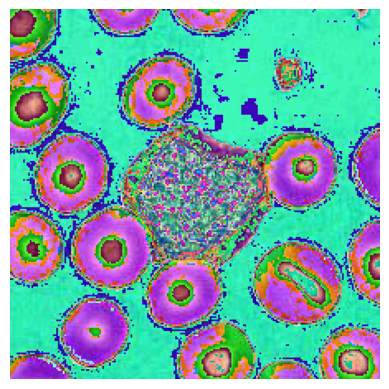

In [23]:
for batch_idx, (images,age, lymph_count , sex , labels , patient_id) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Images shape: {images.shape}")
    print(f"Age and Lymph Count: {[lymph_count,age,sex]}")
    print(f"Labels: {labels}")
    image = transforms.ToPILImage()(images.squeeze()[0])
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    break

# Features Extraction with ResNet18

In [24]:
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models

# Assuming you have a train_loader containing patient data

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50 model
model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft.fc = nn.Identity()
model = model_ft.to(device)
def features_extraction(train_loader,model,DataFrame):
    # Lists to store patient information and extracted features
    patient_data = []
    extracted_features = []

    # Iterate through the dataset
    for batch in train_loader:
        images, age, lyom_count, sex, labels, patient_id = batch
        #print(labels.numpy().item())
        # Move data to device
        images = images.to(device).squeeze()
        # Extract features using ResNet
        with torch.no_grad():
            H = model(images)
            H = torch.mean(H, dim=0)

        # Append patient information and extracted features to lists
        patient_data.append({
            'patient_id': "P" + str(patient_id.item()),
            'label': labels.numpy().item(),
            'age': age.numpy().item(),
            'sex': sex.numpy().item(),
            'lyomuch_count': lyom_count.numpy().item()
        })
        extracted_features.append(H.cpu().numpy())  # Convert tensor to NumPy array and move to CPU


    # Create a DataFrame to store the data
    df = pd.DataFrame(patient_data)

    # Add extracted features to the DataFrame
    for i in range(len(extracted_features[0])):
        df[f'feature_{i+1}'] = [features[i] for features in extracted_features]


    # Save DataFrame to a CSV file
    df.to_csv(DataFrame+'+.csv', index=False)
    return df

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


In [25]:
train_features=features_extraction(train_loader,model,"train_features")

<ipython-input-24-c097be6a9bd5>:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'feature_{i+1}'] = [features[i] for features in extracted_features]
<ipython-input-24-c097be6a9bd5>:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'feature_{i+1}'] = [features[i] for features in extracted_features]
<ipython-input-24-c097be6a9bd5>:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

In [26]:
train_features.head()

,patient_id,label,age,sex,lyomuch_count,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,P96,1,70.0,0,21.27,0.872792,0.938431,0.895050,1.016071,0.847348,...,0.887616,0.849985,0.851567,0.850730,1.064717,0.980988,0.898585,0.924772,1.010549,0.948020
1,P35,1,95.0,0,295.00,0.874789,0.908416,0.897997,1.026148,0.914969,...,0.868856,0.856385,0.873017,0.847220,1.117551,0.972285,0.898047,0.914572,1.038436,0.878295
2,P15,1,64.0,1,138.24,0.858357,0.898965,0.842432,1.007857,0.890684,...,0.868649,0.839391,0.850759,0.842467,1.075428,0.904657,0.889473,0.905303,1.030715,0.940123
3,P26,1,90.0,0,11.20,0.821772,0.909568,0.852733,1.009442,0.815752,...,0.881794,0.864746,0.840145,0.847048,1.112516,0.953203,0.884334,0.901310,1.022534,0.929380
4,P159,0,36.0,0,6.41,0.898151,0.899981,0.903700,0.995914,0.894254,...,0.873980,0.869026,0.887393,0.854660,1.051606,0.923395,0.926609,0.898319,1.019848,0.902255


In [27]:
val_features=features_extraction(val_loader,model,"val_features")
val_features.head()

<ipython-input-24-c097be6a9bd5>:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'feature_{i+1}'] = [features[i] for features in extracted_features]
<ipython-input-24-c097be6a9bd5>:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'feature_{i+1}'] = [features[i] for features in extracted_features]
<ipython-input-24-c097be6a9bd5>:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

,patient_id,label,age,sex,lyomuch_count,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,P97,1,68.0,0,6.75,0.843880,0.929597,0.894705,0.988867,0.855045,...,0.833898,0.857972,0.855293,0.832943,1.036978,0.976850,0.904407,0.915285,1.004437,0.940437
1,P94,1,72.0,0,11.61,0.864042,0.901320,0.869657,0.987732,0.897562,...,0.865364,0.870184,0.821588,0.842709,1.069769,0.957779,0.886473,0.894579,0.982842,0.927264
2,P103,1,99.0,1,5.53,0.876600,0.926462,0.859991,1.023862,0.883591,...,0.867095,0.864696,0.868382,0.853894,1.104016,0.985795,0.864005,0.890738,1.014295,0.941389
3,P22,1,72.0,1,72.56,0.888241,0.900504,0.816139,0.960374,0.865363,...,0.906562,0.852312,0.851137,0.842208,1.095815,0.932099,0.899279,0.919118,1.007492,0.945681
4,P202,1,69.0,0,12.43,0.867860,0.931195,0.895747,0.999713,0.897080,...,0.899883,0.886604,0.861615,0.882466,1.101120,0.963250,0.894503,0.884882,0.994246,0.945471


In [28]:
y_train = train_features['label']
X_train = train_features.drop(columns=['label', 'patient_id'])
X_train = X_train.fillna(1)
y_test = val_features['label']
X_test = val_features.drop(columns=['label', 'patient_id'])

Train our base line model with this new extraccted features :

Accuracy: 0.7272727272727273
Balanced Accuracy: 0.6630434782608696
f1-score: 0.8085106382978724
recall: 0.8260869565217391


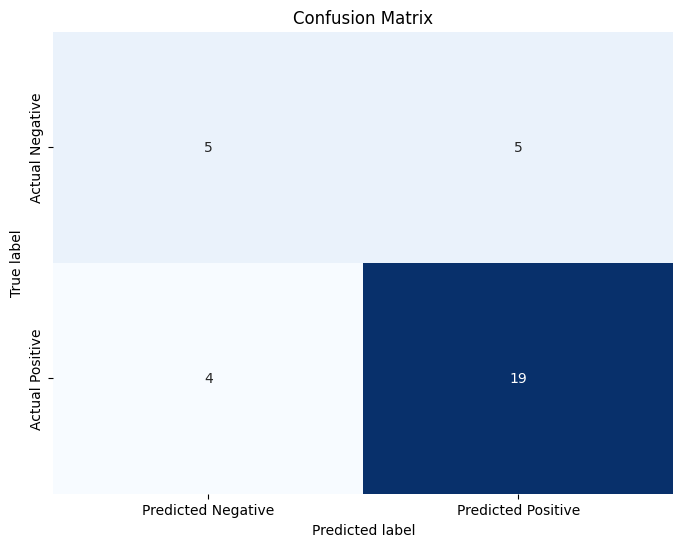

Accuracy: 0.7272727272727273
Balanced Accuracy: 0.6630434782608696
f1-score: 0.8085106382978724
recall: 0.8260869565217391


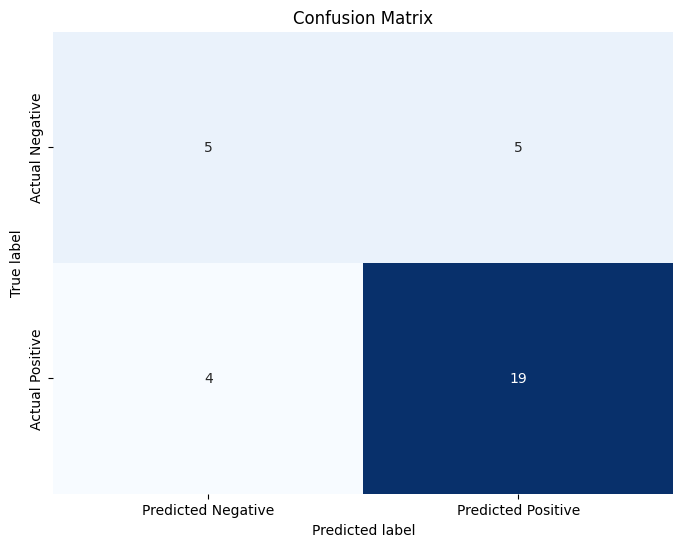

Accuracy: 0.7272727272727273
Balanced Accuracy: 0.6630434782608696
f1-score: 0.8085106382978724
recall: 0.8260869565217391


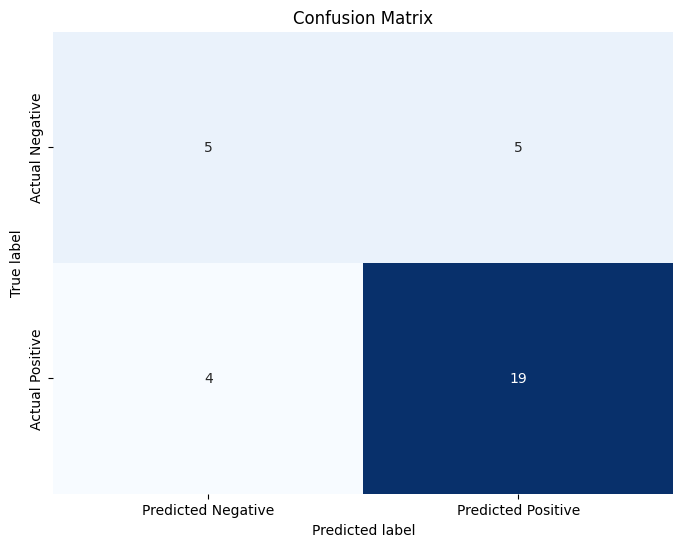

Accuracy: 0.7272727272727273
Balanced Accuracy: 0.6630434782608696


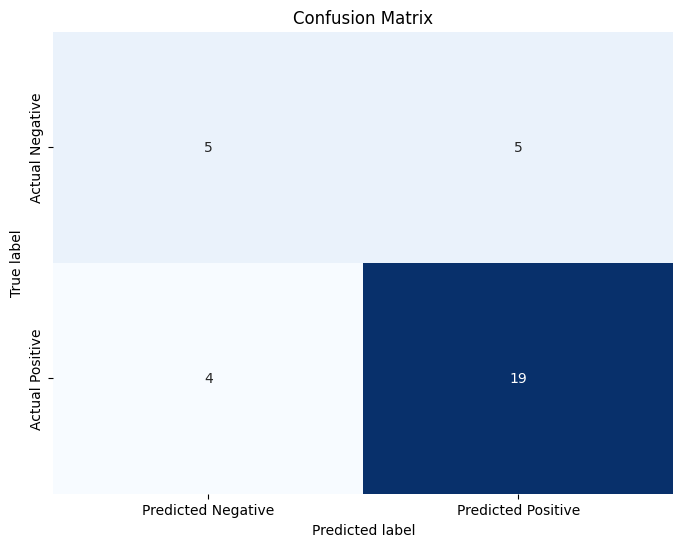

In [29]:
# 3-folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
counter = 0
for train_index, test_index in kf.split(df):
    if counter == 3:
      break
    train_data = train_dt.iloc[train_index]
    test_data = train_dt.iloc[test_index]
    counter+=1

    y_train = train_features['label']
    X_train = train_features.drop(columns=['label', 'patient_id'])
    X_train = X_train.fillna(1)
    y_test = val_features['label']
    X_test = val_features.drop(columns=['label', 'patient_id'])


    # Calculate class weights
    class_weights = dict(zip(y_train.unique(), (1 / y_train.value_counts(normalize=True))))

    # Initialize SVM classifier with class weighting
    model_SVM = SVC(class_weight=class_weights)

    # Train the model
    model_SVM.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = model_SVM.predict(X_test)

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1_s= f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Balanced Accuracy:", balanced_accuracy)
    print("f1-score:", f1_s)
    print("recall:", recall)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()


# Calculate class weights
class_weights = dict(zip(y_train.unique(), (1 / y_train.value_counts(normalize=True))))

# Initialize SVM classifier with class weighting
model_SVM = SVC(class_weight=class_weights)

# Train the model
model_SVM.fit(X_train, y_train)

# Predictions on the test set
y_pred = model_SVM.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# XGboost Classifier

In [30]:
y_train = train_features['label']
X_train = train_features.drop(columns=['label', 'patient_id'])
X_train = X_train.fillna(1)
y_test = val_features['label']
X_test = val_features.drop(columns=['label', 'patient_id'])

In [31]:
# Install
!pip install xgboost
# Import
import xgboost as xgb

In [32]:
# XGBoost (different learning rate)
import numpy as np
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score

learning_rate_range = np.arange(0.01, 1, 0.05)
test_XG = []
train_XG = []

for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta=lr)
    xgb_classifier.fit(X_train, y_train)

    # Predictions
    train_predictions = xgb_classifier.predict(X_train)
    test_predictions = xgb_classifier.predict(X_test)

    # Calculate balanced accuracy
    train_balanced_accuracy = balanced_accuracy_score(y_train, train_predictions)
    test_balanced_accuracy = balanced_accuracy_score(y_test, test_predictions)

    train_XG.append(train_balanced_accuracy)
    test_XG.append(test_balanced_accuracy)

    print(f"Learning Rate: {lr:.2f} - Train Balanced Accuracy: {train_balanced_accuracy:.4f}, Test Balanced Accuracy: {test_balanced_accuracy:.4f}")



Learning Rate: 0.01 - Train Balanced Accuracy: 1.0000, Test Balanced Accuracy: 0.6783
Learning Rate: 0.06 - Train Balanced Accuracy: 1.0000, Test Balanced Accuracy: 0.7065
Learning Rate: 0.11 - Train Balanced Accuracy: 1.0000, Test Balanced Accuracy: 0.7065
Learning Rate: 0.16 - Train Balanced Accuracy: 1.0000, Test Balanced Accuracy: 0.6848
Learning Rate: 0.21 - Train Balanced Accuracy: 1.0000, Test Balanced Accuracy: 0.6630
Learning Rate: 0.26 - Train Balanced Accuracy: 1.0000, Test Balanced Accuracy: 0.7065
Learning Rate: 0.31 - Train Balanced Accuracy: 1.0000, Test Balanced Accuracy: 0.6565
Learning Rate: 0.36 - Train Balanced Accuracy: 1.0000, Test Balanced Accuracy: 0.6348
Learning Rate: 0.41 - Train Balanced Accuracy: 1.0000, Test Balanced Accuracy: 0.7283
Learning Rate: 0.46 - Train Balanced Accuracy: 1.0000, Test Balanced Accuracy: 0.7065
Learning Rate: 0.51 - Train Balanced Accuracy: 1.0000, Test Balanced Accuracy: 0.6565
Learning Rate: 0.56 - Train Balanced Accuracy: 1.0000,

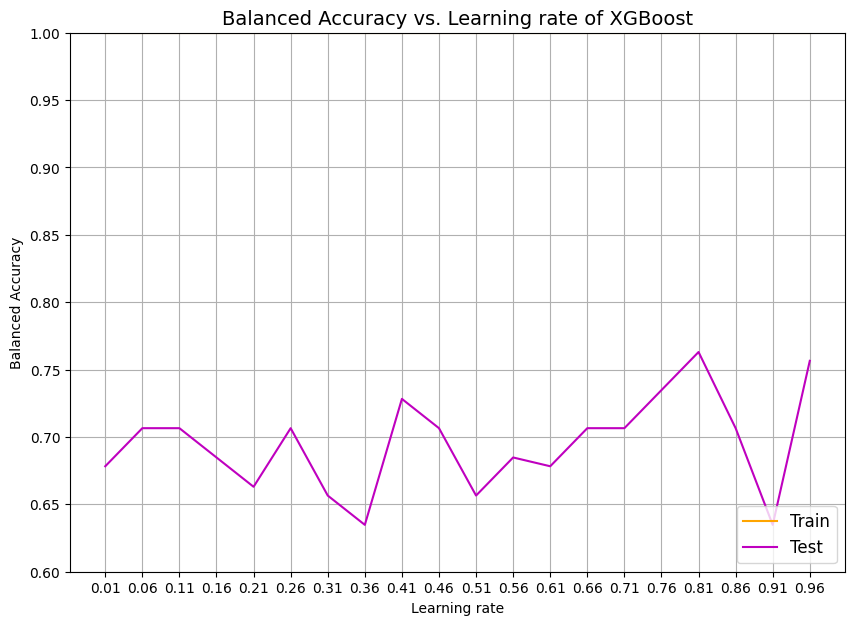

In [33]:
# Plotting
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
plt.plot(learning_rate_range, test_XG, c='m', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Balanced Accuracy')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12}, loc='lower right')
plt.title('Balanced Accuracy vs. Learning rate of XGBoost', size=14)
plt.grid(True)
plt.show()

Submit

In [35]:
test_data_dir = '/content/testset/'
test_dataset = CustomDataset(test_data_dir, test_dt, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_features=features_extraction(test_loader, model_ft.to(device),"test_features")

y_test_ = test_features['label']
X_test_ = test_features.drop(columns=['label', 'patient_id'])
X_test_ = X_test_.fillna(1)

y_pred = xgb_classifier.predict(X_test_)

submission_df = pd.DataFrame({'ID': test_features["patient_id"], 'Predicted': y_pred})

# Save DataFrame to a CSV file
submission_df.to_csv('xgbsubmission23.csv', index=False)

<ipython-input-24-c097be6a9bd5>:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'feature_{i+1}'] = [features[i] for features in extracted_features]
<ipython-input-24-c097be6a9bd5>:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'feature_{i+1}'] = [features[i] for features in extracted_features]
<ipython-input-24-c097be6a9bd5>:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

# MLP model classifier

In [36]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size=515, hidden_size=256):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)  # Output layer with one neuron for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [37]:
train_features.head()

,patient_id,label,age,sex,lyomuch_count,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,P96,1,70.0,0,21.27,0.872792,0.938431,0.895050,1.016071,0.847348,...,0.887616,0.849985,0.851567,0.850730,1.064717,0.980988,0.898585,0.924772,1.010549,0.948020
1,P35,1,95.0,0,295.00,0.874789,0.908416,0.897997,1.026148,0.914969,...,0.868856,0.856385,0.873017,0.847220,1.117551,0.972285,0.898047,0.914572,1.038436,0.878295
2,P15,1,64.0,1,138.24,0.858357,0.898965,0.842432,1.007857,0.890684,...,0.868649,0.839391,0.850759,0.842467,1.075428,0.904657,0.889473,0.905303,1.030715,0.940123
3,P26,1,90.0,0,11.20,0.821772,0.909568,0.852733,1.009442,0.815752,...,0.881794,0.864746,0.840145,0.847048,1.112516,0.953203,0.884334,0.901310,1.022534,0.929380
4,P159,0,36.0,0,6.41,0.898151,0.899981,0.903700,0.995914,0.894254,...,0.873980,0.869026,0.887393,0.854660,1.051606,0.923395,0.926609,0.898319,1.019848,0.902255


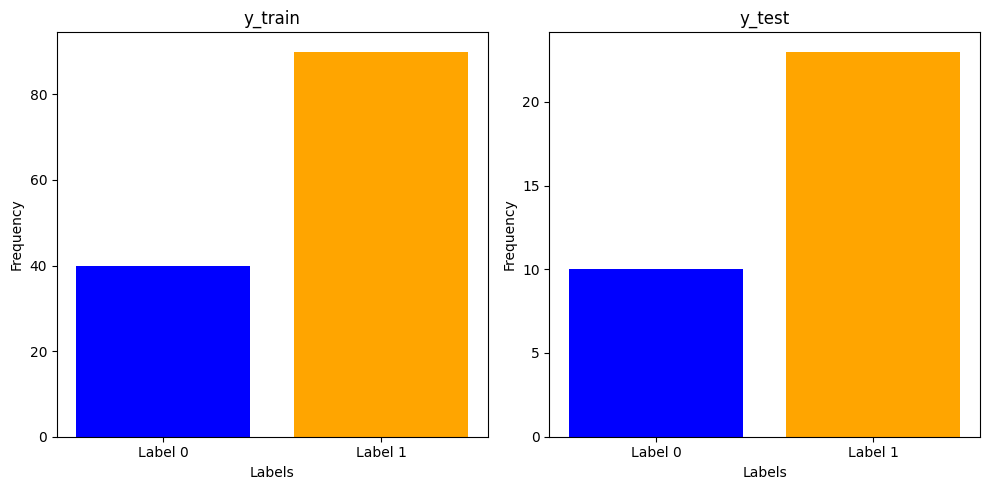

In [38]:
import numpy as np
# Unique labels and their counts
unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
unique_labels_test, counts_test = np.unique(y_test, return_counts=True)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Train data
ax1.bar(unique_labels_train, counts_train, color=['blue', 'orange'])
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Label 0', 'Label 1'])
ax1.set_title('y_train')
ax1.set_xlabel('Labels')
ax1.set_ylabel('Frequency')

# Test data
ax2.bar(unique_labels_test, counts_test, color=['blue', 'orange'])
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Label 0', 'Label 1'])
ax2.set_title('y_test')
ax2.set_xlabel('Labels')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [46]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Define a custom dataset class
class CustomDataset2(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Extract features and labels for the given index
        x = torch.tensor(self.features.iloc[idx].values, dtype=torch.float32)
        y = torch.tensor(self.labels.iloc[idx], dtype=torch.float32)
        return x, y

# Assuming you have defined X_train, y_train, X_test, and y_test

# Create train and test datasets
train_dataset = CustomDataset2(X_train, y_train)
test_dataset = CustomDataset2(X_test, y_test)

# Define batch size
batch_size = 8

# Create DataLoader for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [47]:
# Initialize the model, loss function, and optimizer

pos_weight = torch.tensor([0.4])  # Adjust according to class imbalance

# Define the criterion using BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Initialize the model and optimizer
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [48]:
# Train the model
from sklearn.metrics import balanced_accuracy_score

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    predictions_train = []
    true_labels_train = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs=outputs.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        outputs = torch.sigmoid(outputs)
        predictions_train.extend(torch.round(outputs).squeeze().tolist())
        true_labels_train.extend(labels.tolist())
    train_loss /= len(train_loader.dataset)
    balanced_acc_train = balanced_accuracy_score(true_labels_train, predictions_train)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Balanced Accuracy: {balanced_acc_train:.4f}")

    # Evaluate the model
    model.eval()
    test_loss = 0.0
    predictions_test = []
    true_labels_test = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            outputs = torch.sigmoid(outputs)
            predicted = torch.round(outputs)
            predictions_test.extend(predicted.tolist())
            true_labels_test.extend(labels.tolist())
    test_loss /= len(test_loader.dataset)
    balanced_acc_test = balanced_accuracy_score(true_labels_test, predictions_test)
    print(f"Test Loss: {test_loss:.4f}, Balanced Accuracy: {balanced_acc_test:.4f}")

Epoch 1/100, Train Loss: 0.5124, Balanced Accuracy: 0.5375
Test Loss: 0.3727, Balanced Accuracy: 0.6087
Epoch 2/100, Train Loss: 0.3151, Balanced Accuracy: 0.7264
Test Loss: 0.3005, Balanced Accuracy: 0.8261
Epoch 3/100, Train Loss: 0.3157, Balanced Accuracy: 0.6500
Test Loss: 0.3624, Balanced Accuracy: 0.5783
Epoch 4/100, Train Loss: 0.2570, Balanced Accuracy: 0.7917
Test Loss: 0.2790, Balanced Accuracy: 0.8043
Epoch 5/100, Train Loss: 0.2395, Balanced Accuracy: 0.8056
Test Loss: 0.2769, Balanced Accuracy: 0.7196
Epoch 6/100, Train Loss: 0.2500, Balanced Accuracy: 0.7833
Test Loss: 0.2731, Balanced Accuracy: 0.7196
Epoch 7/100, Train Loss: 0.2287, Balanced Accuracy: 0.7931
Test Loss: 0.3981, Balanced Accuracy: 0.5783
Epoch 8/100, Train Loss: 0.1997, Balanced Accuracy: 0.8597
Test Loss: 0.3004, Balanced Accuracy: 0.7609
Epoch 9/100, Train Loss: 0.2498, Balanced Accuracy: 0.7944
Test Loss: 0.2831, Balanced Accuracy: 0.6630
Epoch 10/100, Train Loss: 0.2051, Balanced Accuracy: 0.8319
Test

# Submit to Competition

In [45]:
test_data_dir = '/content/testset/'
test_dataset = CustomDataset(test_data_dir, test_dt, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
test_features=features_extraction(test_loader, model_ft.to(device),"test_features")
y_test_ = test_features['label']
X_test_ = test_features.drop(columns=['label', 'patient_id'])
X_test_ = X_test_.fillna(1)
predictions_test = []
for index, row in X_test_.iterrows():
    outputs = model(torch.tensor(row.values, dtype=torch.float).unsqueeze(0))
    outputs = torch.sigmoid(outputs)
    predicted = torch.round(outputs).item()
    predictions_test.append(int(predicted))

submission_df = pd.DataFrame({'ID': test_features["patient_id"], 'Predicted': predictions_test})

# Save DataFrame to a CSV file
submission_df.to_csv('mpl_model02.csv', index=False)

<ipython-input-24-c097be6a9bd5>:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'feature_{i+1}'] = [features[i] for features in extracted_features]
<ipython-input-24-c097be6a9bd5>:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'feature_{i+1}'] = [features[i] for features in extracted_features]
<ipython-input-24-c097be6a9bd5>:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

## Full script for 3-folds cross-validation ( min to run )

In [50]:
import torchvision.models as models
from sklearn.metrics import f1_score, recall_score, balanced_accuracy_score
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

train_data_dir = '/content/trainset/'
# Load annotation data
train_dt = pd.read_csv("/content/trainset/trainset_true.csv")
train_dt.head()

########### parameters ###########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load pre-trained ResNet50 model
model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft.fc = nn.Identity()
model = model_ft.to(device)
feature_extractor = model

pos_weight = torch.tensor([0.4])  # Adjust according to class imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
lr = 0.001
batch_size = 8
num_epochs = 100
##################################


for fold in [1, 2, 3]:
  print(f"Current fold : {fold}")


  # Load annotation data
  train_dt = pd.read_csv("/content/trainset/trainset_true.csv")
  train_dt.head()
  train_dt['DOB'] = pd.to_datetime(train_dt['DOB'])
  train_dt['Age'] = (pd.Timestamp.now() - train_dt['DOB']).astype('<m8[Y]')
  gender_mapping = {'M': 0, 'F': 1,'f': 1}
  train_dt['SEX'] = train_dt['GENDER'].map(gender_mapping)

  #first  step : features extraction from images
  #load the fold

  train_dataset = CustomDataset(train_data_dir, train_dt, transform=transform,
                                split='train', fold=fold)
  val_dataset = CustomDataset(train_data_dir, train_dt, transform=transform, #normalisation are done separately to prevent data leakage
                              split='val', fold=fold)
  random.seed(42)  #for reproducibility
  train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

  print("features extraction")
  train_features = features_extraction(train_loader, feature_extractor,
                                      "train_features")
  val_features = features_extraction(val_loader, feature_extractor,
                                        "val_features")

  #concatenate medical information with extracted features
  y_train = train_features['label']
  X_train = train_features.drop(columns=['label', 'patient_id'])
  X_train = X_train.fillna(1)
  y_test = val_features['label']
  X_test = val_features.drop(columns=['label', 'patient_id'])


  #uncomment and comment the following if you want to use SVM
  """
  # Calculate class weights
  class_weights = dict(zip(y_train.unique(), (1 / y_train.value_counts(normalize=True))))

  # Initialize SVM classifier with class weighting
  model_SVM = SVC(class_weight=class_weights)

  # Train the model
  model_SVM.fit(X_train, y_train)

  # Predictions on the test set
  y_pred = model_SVM.predict(X_test)

  # Evaluate model performance
  accuracy = accuracy_score(y_test, y_pred)
  balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
  f1_s= f1_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  print("Accuracy:", accuracy)
  print("Balanced Accuracy:", balanced_accuracy)
  print("f1-score:", f1_s)
  print("recall:", recall)

  # Calculate confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
  xticklabels=['Predicted Negative', 'Predicted Positive'],
  yticklabels=['Actual Negative', 'Actual Positive'])
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion Matrix')
  plt.show()
  """
  #step 2 : Training
  #load the final data
  train_dataset = CustomDataset2(X_train, y_train)
  test_dataset = CustomDataset2(X_test, y_test)
  random.seed(42)  #for reproducibility
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  #training
  # Initialize the model, loss function, and optimizer
  random.seed(42)  #for reproducibility
  model = MLP(515, 256)
  optimizer = optim.Adam(model.parameters(), lr=lr)



  for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    predictions_train = []
    true_labels_train = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs=outputs.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        outputs = torch.sigmoid(outputs)
        predictions_train.extend(torch.round(outputs).squeeze().tolist())
        true_labels_train.extend(labels.tolist())
    train_loss /= len(train_loader.dataset)
    balanced_acc_train = balanced_accuracy_score(true_labels_train, predictions_train)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Balanced Accuracy: {balanced_acc_train:.4f}")

    # Evaluate the model
    model.eval()
    test_loss = 0.0
    predictions_test = []
    true_labels_test = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            outputs = torch.sigmoid(outputs)
            predicted = torch.round(outputs)
            predictions_test.extend(predicted.tolist())
            true_labels_test.extend(labels.tolist())
    test_loss /= len(test_loader.dataset)
    balanced_acc_test = balanced_accuracy_score(true_labels_test, predictions_test)
    f1_score_test = f1_score(true_labels_test, predictions_test)
    recall_test = recall_score(true_labels_test, predictions_test)
    print(f"Test Loss: {test_loss:.4f}, Balanced Accuracy: {balanced_acc_test:.4f}, F1-Score:{f1_score_test:.4f}, Recall:{recall_test:.4f}")
  #print metrics on the validation test at the end of the training
  print(f"""On validation fold {fold} the metrics are:
                     Balanced Accuracy: {balanced_acc_test:.4f},
                     F1-Score:          {f1_score_test:.4f},
                     Recall:            {recall_test:.4f}
         """ )

Current fold : 1
features extraction
Epoch 1/100, Train Loss: 0.4769, Balanced Accuracy: 0.5194
Test Loss: 0.2983, Balanced Accuracy: 0.7391, F1-Score:0.6471, Recall:0.4783
Epoch 2/100, Train Loss: 0.2915, Balanced Accuracy: 0.7625
Test Loss: 0.2889, Balanced Accuracy: 0.6739, F1-Score:0.5161, Recall:0.3478
Epoch 3/100, Train Loss: 0.2598, Balanced Accuracy: 0.7681
Test Loss: 0.2521, Balanced Accuracy: 0.8500, F1-Score:0.9388, Recall:1.0000
Epoch 4/100, Train Loss: 0.3072, Balanced Accuracy: 0.7083
Test Loss: 0.2336, Balanced Accuracy: 0.8500, F1-Score:0.9388, Recall:1.0000
Epoch 5/100, Train Loss: 0.2286, Balanced Accuracy: 0.8028
Test Loss: 0.2222, Balanced Accuracy: 0.7978, F1-Score:0.8000, Recall:0.6957
Epoch 6/100, Train Loss: 0.2929, Balanced Accuracy: 0.7458
Test Loss: 0.2048, Balanced Accuracy: 0.8130, F1-Score:0.8636, Recall:0.8261
Epoch 7/100, Train Loss: 0.2672, Balanced Accuracy: 0.7625
Test Loss: 0.2047, Balanced Accuracy: 0.7978, F1-Score:0.8000, Recall:0.6957
Epoch 8/100

In [54]:

test_data_dir = '/content/testset/'
test_dataset = CustomDataset(test_data_dir, test_dt, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
test_features=features_extraction(test_loader, model_ft.to(device),"test_features")

y_test_ = test_features['label']
X_test_ = test_features.drop(columns=['label', 'patient_id'])
X_test_ = X_test_.fillna(1)
predictions_test = []
for index, row in X_test_.iterrows():
    outputs = model(torch.tensor(row.values, dtype=torch.float).unsqueeze(0))
    outputs = torch.sigmoid(outputs)
    predicted = torch.round(outputs).item()
    predictions_test.append(int(predicted))

submission_df = pd.DataFrame({'ID': test_features["patient_id"], 'Predicted': predictions_test})

# Save DataFrame to a CSV file
submission_df.to_csv('mpl_model.csv', index=False)